1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


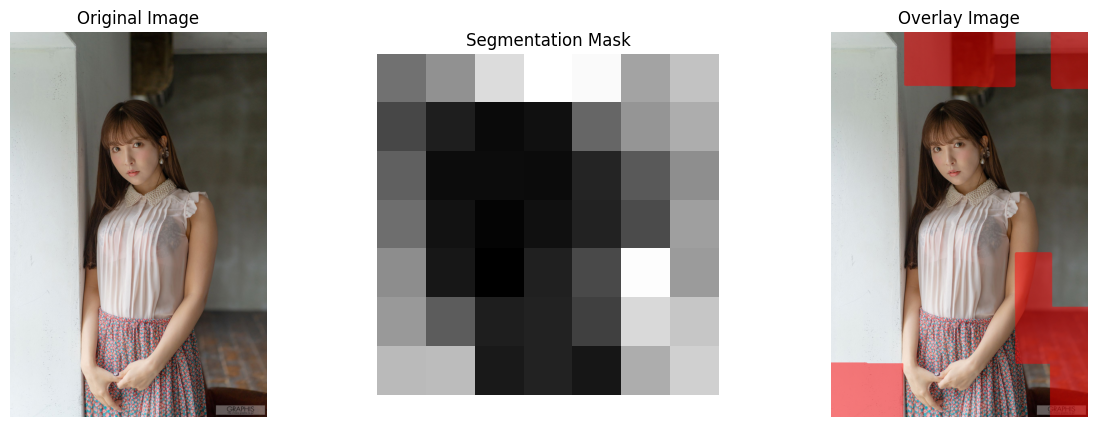

In [65]:
import os
import ssl
import certifi
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, UpSampling2D
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set SSL_CERT_FILE environment variable to avoid potential issues
os.environ['SSL_CERT_FILE'] = certifi.where()

# Load base MobileNetV2 model without the top classification layers
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)

# Path to the locally downloaded weights file
weights_path = './mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
base_model.load_weights(weights_path)

# Modify the model for segmentation
x = base_model.output
x = UpSampling2D(size=(7, 7))(x)  # Upsample to roughly match the input size
x = Conv2D(1, (1, 1), activation='sigmoid')(x)
x = UpSampling2D(size=(2, 2))(x)  # Further upsample to match the input size

segmentation_model = tf.keras.Model(inputs=base_model.input, outputs=x)

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (224, 224))
    image_normalized = image_resized / 255.0
    return image, image_normalized

original_image, preprocessed_image = load_and_preprocess_image('./test.jpg')
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

prediction = segmentation_model.predict(preprocessed_image)
segmentation_mask = prediction[0]

def create_overlay(original_image, segmentation_mask, alpha=0.5):
    segmentation_mask_resized = cv2.resize(segmentation_mask, (original_image.shape[1], original_image.shape[0]))
    overlay = original_image.copy()
    overlay[segmentation_mask_resized > 0.5] = (255, 0, 0)  # Red color for overlay
    combined = cv2.addWeighted(original_image, 1 - alpha, overlay, alpha, 0)
    return combined

overlay_image = create_overlay(original_image, segmentation_mask)

def plot_results(original_image, segmentation_mask, overlay_image):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_image)
    plt.title('Overlay Image')
    plt.axis('off')

    plt.show()

plot_results(original_image, segmentation_mask, overlay_image)
